In [17]:
import os
import pygame
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
import time
import random
from collections import deque
import matplotlib.pyplot as plt
from IPython import display
from Core_Game_Parts import *

os.environ["SDL_VIDEODRIVER"] = "dummy"

In [18]:
def model_rl():
    """Builds the model with a linear output layer suitable for Q-learning."""
    net = Sequential([
        Dense(64, activation='relu', input_shape=(4,)),
        Dense(64, activation='relu'),
        Dense(3, activation='linear') # Linear output for Q-values
    ])
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
    net.compile(optimizer=optimizer, loss='mse')
    return net


In [19]:
class DQNAgent:
    """
    A Deep Q-Network (DQN) agent for reinforcement learning.
    Attributes:
        model: The neural network model used for approximating Q-values.
        memory: A deque to store past experiences for experience replay.
        gamma: Discount factor for future rewards.
        epsilon: Exploration rate for the epsilon-greedy policy.
        epsilon_min: Minimum exploration rate.
        epsilon_decay: Decay rate for exploration after each training episode.
        batch_size: Size of the minibatch for training.
    Methods:
        remember: Store an experience in memory.
        choose_action: Select an action based on the current state using an epsilon-greedy policy.
        train_from_memory: Train the model using a minibatch of experiences from memory.
    """
    def __init__(self, model_fn):
        self.model = model_fn()
        self.target_model = model_fn()
        self.update_target_model()
        self.memory = deque(maxlen=30000)
        self.gamma = 0.99
        self.epsilon = 1.0 # Will be reset after loading weights
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.9995
        self.batch_size = 128

    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def choose_action(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(3)
        q_values = self.model.predict(np.reshape(state, [1, 4]), verbose=0)
        return np.argmax(q_values[0])

    def train_from_memory(self):
        if len(self.memory) < self.batch_size:
            return None

        minibatch = random.sample(self.memory, self.batch_size)
        states = np.array([exp[0] for exp in minibatch])
        actions = np.array([exp[1] for exp in minibatch])
        rewards = np.array([exp[2] for exp in minibatch])
        next_states = np.array([exp[3] for exp in minibatch])
        dones = np.array([exp[4] for exp in minibatch])

        # --- THIS IS THE DOUBLE DQN UPGRADE ---
        # 1. Use the main model to select the best action for the next state
        next_actions = np.argmax(self.model.predict(next_states, verbose=0), axis=1)
        # 2. Use the target model to evaluate the Q-value of that selected action
        next_q_values = self.target_model.predict(next_states, verbose=0)
        
        target_q_values = np.zeros(self.batch_size)
        for i in range(self.batch_size):
            target_q_values[i] = next_q_values[i][next_actions[i]]

        targets = rewards + self.gamma * target_q_values * (1 - dones)
        # --- END OF UPGRADE ---
        
        current_q_values = self.model.predict(states, verbose=0)
        for i, action in enumerate(actions):
            current_q_values[i][action] = targets[i]
            
        history = self.model.fit(states, current_q_values, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        return history.history['loss'][0]


In [20]:
def model_game_step(action, car, track_image, current_checkpoint):
    done = False
    
    # Simple, positive reward for speed and having a clear path
    reward = car.speed * 0.1
    current_state, _ = ray_casting(car, track_image)
    reward += current_state[1] * 0.01

    # Standard physics
    car.speed += ACCELERATION
    if car.speed > 0:
        turn = MAX_TURN_ANGLE - (car.speed/MAX_SPEED)*(MAX_TURN_ANGLE-MIN_TURN_ANGLE)
        if action == 0: 
            car.angle += turn
            reward -= 0.001
        elif action == 1: 
            car.angle -= turn
            reward -= 0.001
    if action == 2: 
        car.speed -= BRAKE_FORCE
        reward += 0.01
    car.speed -= FRICTION; car.speed = max(0, min(car.speed, MAX_SPEED)); car.move()
    
    # Goal rewards
    checkpoint_rects = [pygame.Rect(x,y,w,h) for x,y,w,h,a in checkpoint_data]
    if current_checkpoint < len(checkpoint_rects):
        if car.rect.colliderect(checkpoint_rects[current_checkpoint]):
            current_checkpoint += 1; reward += 1000
            print(f"Checkpoint {current_checkpoint} reached!")
            
    # CRASH PENALTY (Corrected)
    try:
        # The car crashes if it hits the WALL (BG_COLOR)
        if track_image.get_at((int(car.x), int(car.y)))[:3] == DRAW_COLOR:
            done = True
    except IndexError:
        done = True # Or goes off-screen
    if done:
        reward = -100

    new_state, _ = ray_casting(car, track_image)
    return new_state, done, reward, current_checkpoint


In [21]:
class DynamicPlotter:
    """
    A class to handle creating and dynamically updating matplotlib plots in a Jupyter/Colab notebook.
    """
    def __init__(self, episodes):
        self.fig, self.axes = plt.subplots(5, 1, figsize=(12, 28))
        self.ax1, self.ax2, self.ax3, self.ax4, self.ax5 = self.axes
        
        # Display the initial empty figure
        self.display_handle = display.display(self.fig, display_id=True)
        self.episodes = episodes

    def update(self, history_data):
        # Clear all axes to redraw them
        for ax in self.axes:
            ax.clear()

        # --- Graph 1: Score ---
        self.ax1.plot(history_data['scores'], label='Score per Episode', color='royalblue')
        self.ax1.set(title='Agent Score Over Time', xlabel='Episode', ylabel='Total Reward')
        self.ax1.legend()

        # --- Graph 2: Max Speed ---
        self.ax2.plot(history_data['max_speed'], label='Max Speed', color='purple')
        self.ax2.set(title='Max Speed Achieved per Episode', xlabel='Episode', ylabel='Max Speed')
        self.ax2.legend()
        
        # --- Graph 3: Model Loss ---
        self.ax3.plot(history_data['loss'], label='Training Loss', color='orangered', alpha=0.7)
        self.ax3.set(title='Model Loss Over Time', xlabel='Training Step', ylabel='MSE Loss')
        self.ax3.legend()

        # --- Graph 4: Checkpoints Bar Chart ---
        episodes_range = range(len(history_data['checkpoints']))
        self.ax4.bar(episodes_range, history_data['checkpoints'], color='forestgreen', label='Checkpoints')
        self.ax4.set(title='Checkpoints Cleared per Episode', xlabel='Episode', ylabel='Checkpoints Cleared')
        self.ax4.yaxis.set_major_locator(plt.MaxNLocator(integer=True))
        self.ax4.legend()

        # --- Graph 5: Episode Duration ---
        self.ax5.plot(history_data['episode_times'], label='Episode Duration', color='goldenrod')
        self.ax5.set(title='Episode Duration Over Time', xlabel='Episode', ylabel='Time (seconds)')
        self.ax5.legend()
        
        plt.tight_layout()
        
        # Update the display in the same output cell
        self.display_handle.update(self.fig)

def train_dqn_finetune(episodes=500, pretrained_weights_path="pretrained_weights.h5"):
    pygame.init()
    track_surface = pygame.image.load(TRACK_IMAGE_PATH).convert()
    agent = DQNAgent(model_rl) # Assumes DQNAgent and model_rl are defined above

    try:
        agent.model.load_weights(pretrained_weights_path)
        agent.update_target_model()
        print(f"Successfully loaded pre-trained weights from {pretrained_weights_path}")
    except Exception as e:
        print(f"Could not load pre-trained weights: {e}. Starting from scratch.")

    agent.epsilon = 0.1
    print(f"Starting fine-tuning with epsilon = {agent.epsilon}")
    
    history_data = {'scores': [], 'loss': [], 'checkpoints': [], 'max_speed': [], 'episode_times': []}
    
    # Initialize the dynamic plotter
    plotter = DynamicPlotter(episodes)
    
    for e in range(episodes):
        episode_start_time = time.time()
        car = Car(CAR_IMAGE_PATH, DEFAULT_START_X, DEFAULT_START_Y, DEFAULT_START_ANGLE)
        current_checkpoint, total_reward, max_speed_episode = 0, 0, 0
        distances, _ = ray_casting(car, track_surface)
        state = np.array(distances + [car.speed / MAX_SPEED])
        
        for step in range(10000): # Max steps per episode
            action = agent.choose_action(state)
            distances_next, done, reward, new_checkpoint = model_game_step(action, car, track_surface, current_checkpoint)
            
            max_speed_episode = max(max_speed_episode, car.speed)
            total_reward += reward
            next_state = np.array(distances_next + [car.speed / MAX_SPEED])
            current_checkpoint = new_checkpoint
            
            agent.remember(state, action, reward, next_state, done)
            state = next_state
            
            if step % 16 == 0:
                loss = agent.train_from_memory()
                if loss is not None: history_data['loss'].append(loss)
            
            if done:
                break
                
        episode_time = time.time() - episode_start_time
        history_data['episode_times'].append(episode_time)
        
        if (e + 1) % 5 == 0:
            agent.update_target_model()
            print(f"--- Target Network Updated at Episode {e+1} ---")
            
        history_data['scores'].append(total_reward)
        history_data['checkpoints'].append(current_checkpoint)
        history_data['max_speed'].append(max_speed_episode)
        
        print(f"E{e+1}/{episodes}, Score:{total_reward:.2f}, Max speed:{max_speed_episode:.2f}, Ckpt:{current_checkpoint}, Time:{episode_time:.2f}s")
        # Update the graphs every 5 episodes
        if (e + 1) % 5 == 0:
            plotter.update(history_data)
            
        if (e + 1) % 50 == 0:
            agent.model.save_weights(f"a_finetuned_weights_episode_{e+1}.weights.h5")
            print(f"Saved fine-tuned weights at episode {e+1}")

    pygame.quit()
    
    # Final plot update to show the very last episode's data
    print("Training complete. Displaying final graphs.")
    plotter.update(history_data)

# --- Start the Dynamic Training ---

c:\Users\Yash\OneDrive\Desktop\Neural Networks Car Project\.venv\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\Yash\OneDrive\Desktop\Neural Networks Car Project\.venv\Lib\site-packages\keras\src\saving\saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Successfully loaded pre-trained weights from finetuned_weights_episode_550.weights.h5
Starting fine-tuning with epsilon = 0.1


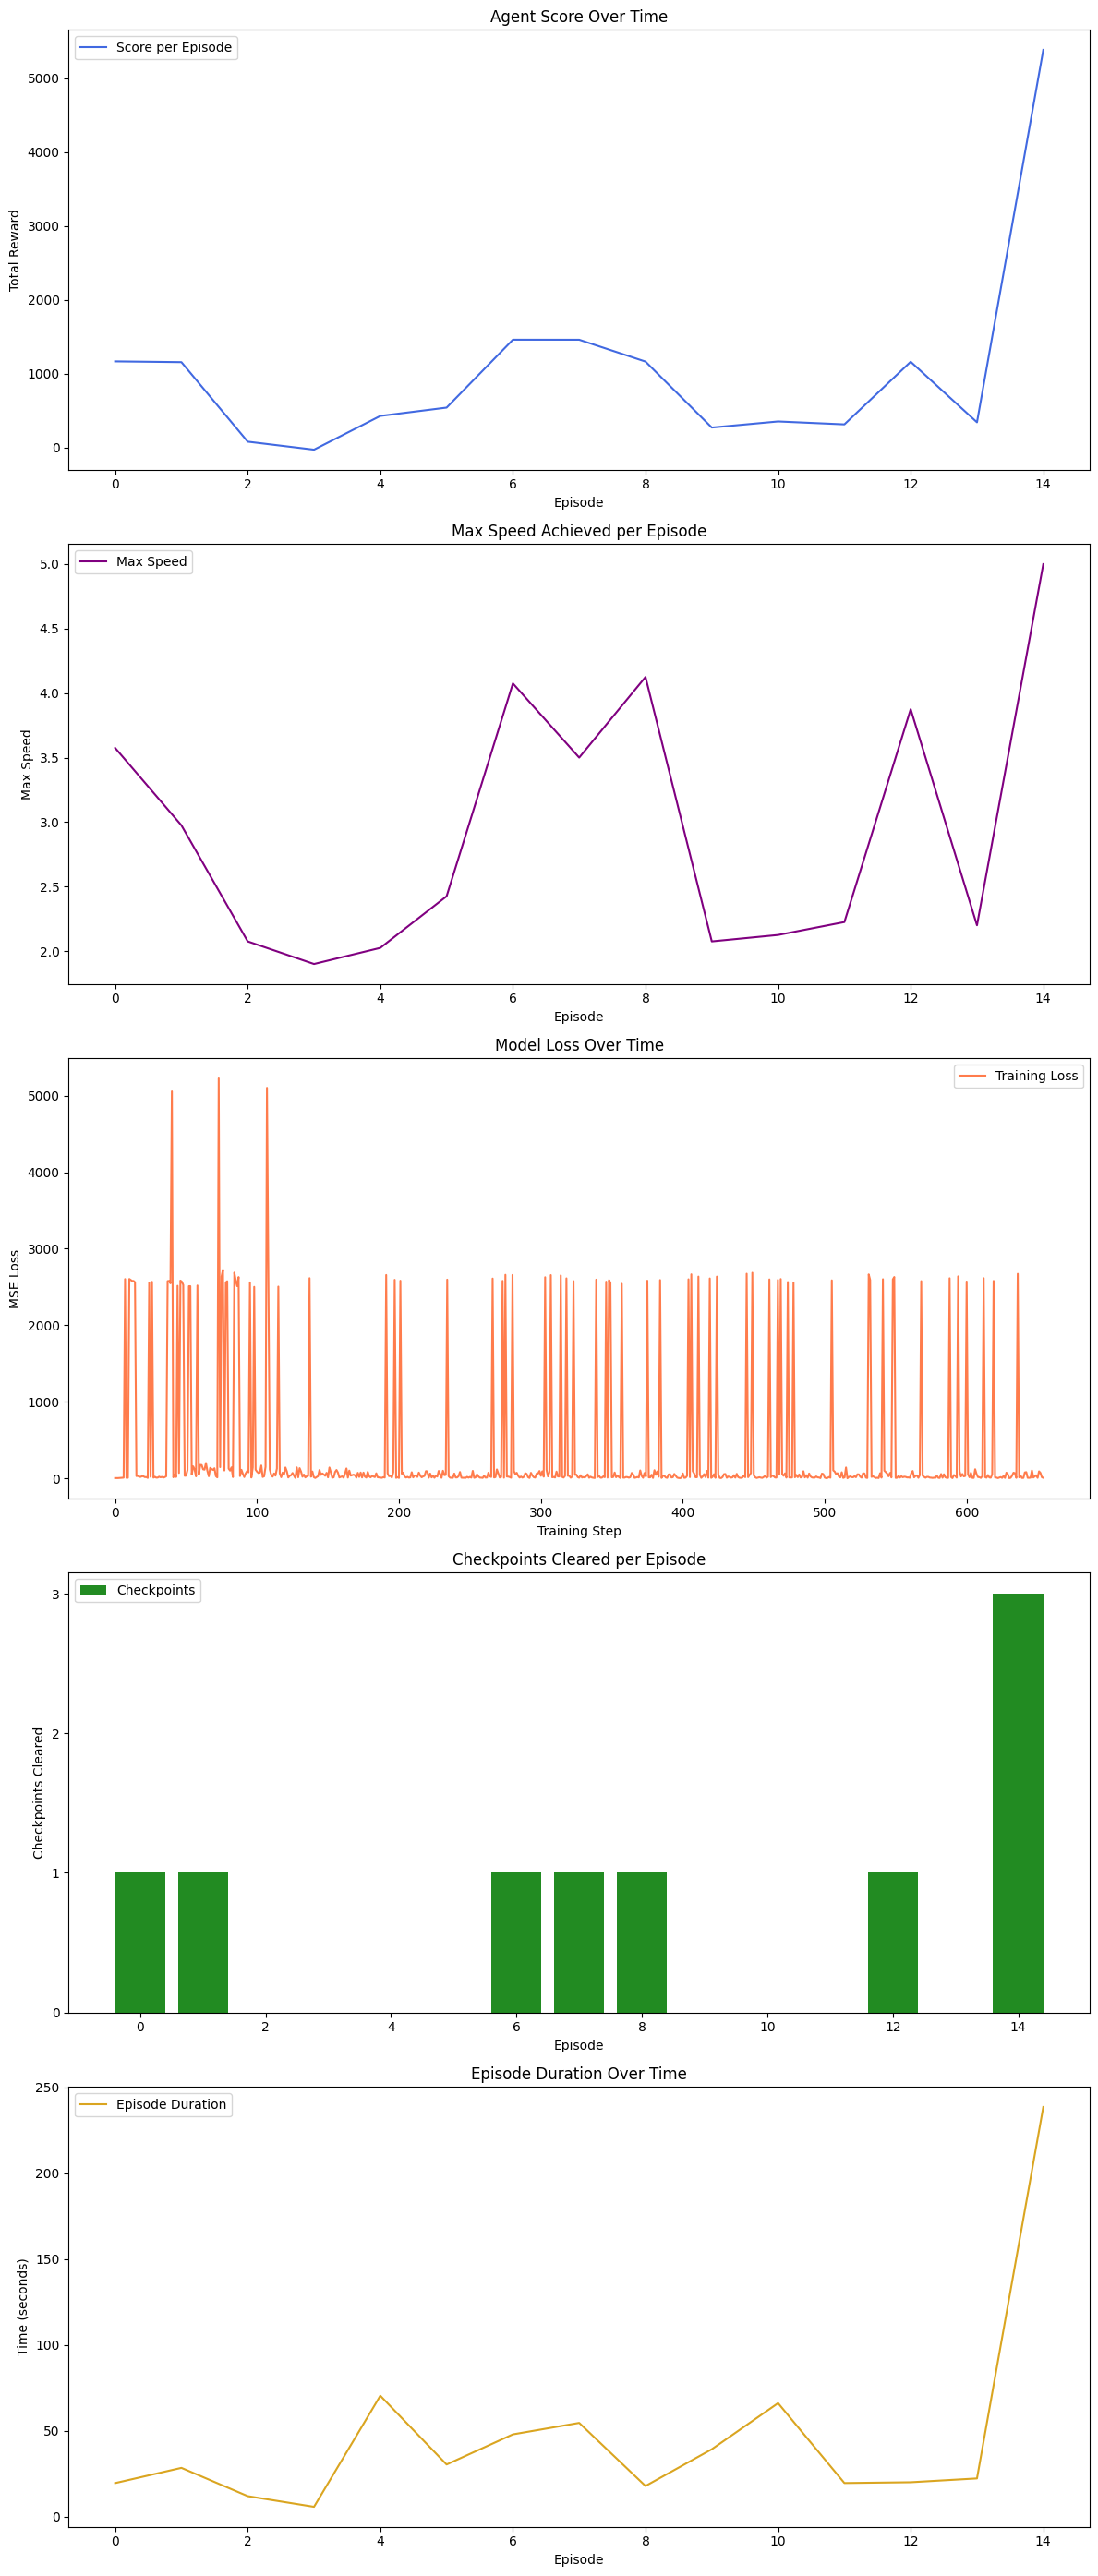

Checkpoint 1 reached!
E1/1000, Score:1167.79, Max speed:3.58, Ckpt:1, Time:19.62s
Checkpoint 1 reached!
E2/1000, Score:1157.42, Max speed:2.98, Ckpt:1, Time:28.49s
E3/1000, Score:81.57, Max speed:2.08, Ckpt:0, Time:12.04s
E4/1000, Score:-26.92, Max speed:1.90, Ckpt:0, Time:5.82s
--- Target Network Updated at Episode 5 ---
E5/1000, Score:429.51, Max speed:2.03, Ckpt:0, Time:70.47s
E6/1000, Score:542.39, Max speed:2.43, Ckpt:0, Time:30.46s
Checkpoint 1 reached!
E7/1000, Score:1461.08, Max speed:4.07, Ckpt:1, Time:47.99s
Checkpoint 1 reached!
E8/1000, Score:1460.58, Max speed:3.50, Ckpt:1, Time:54.67s
Checkpoint 1 reached!
E9/1000, Score:1164.97, Max speed:4.12, Ckpt:1, Time:17.94s
--- Target Network Updated at Episode 10 ---
E10/1000, Score:272.48, Max speed:2.08, Ckpt:0, Time:39.34s
E11/1000, Score:354.92, Max speed:2.13, Ckpt:0, Time:66.17s
E12/1000, Score:315.44, Max speed:2.23, Ckpt:0, Time:19.65s
Checkpoint 1 reached!
E13/1000, Score:1162.65, Max speed:3.87, Ckpt:1, Time:20.12s
E14/

In [ ]:
if __name__=="__main__":
    train_dqn_finetune(episodes=1000, pretrained_weights_path="finetuned_weights_episode_550.weights.h5")